Obiettivo: prevedere il costo totale di una prenotazione e integrare il risultato come nuova colonna nei dati.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from pathlib import Path


In [0]:

# --- 1. Caricamento e Unione di TUTTE le tabelle Silver in SPARK ---
catalog = "catalog_progetto_finale"
schema = "silver_schema_pf"

bookings_df_spark = spark.read.table(f"{catalog}.{schema}.bookings_silver")
rooms_df_spark = spark.read.table(f"{catalog}.{schema}.rooms_silver")
hotels_df_spark = spark.read.table(f"{catalog}.{schema}.hotels_silver")

#creo una lista completa di ogni prenotazione unendo le tre tabelle
data_spark_df = bookings_df_spark.join(rooms_df_spark, "room_id") \
                                    .join(hotels_df_spark, "hotel_id")

data = data_spark_df.toPandas()
#elimina eventuali colonne duplicate durante il join
data = data.loc[:, ~data.columns.duplicated()]

print("✅ Dati caricati e uniti con successo.")


✅ Dati caricati e uniti con successo.


In [0]:

# --- 2. Feature Engineering e Pulizia in Pandas ---
data['checkin_date'] = pd.to_datetime(data['checkin_date'], errors='coerce')
data['checkout_date'] = pd.to_datetime(data['checkout_date'], errors='coerce')

data['duration_of_stay'] = (data['checkout_date'] - data['checkin_date']).dt.days
data['booking_month'] = data['checkin_date'].dt.month
data['day_of_week_checkin'] = data['checkin_date'].dt.dayofweek

numeric_cols = ['duration_of_stay', 'max_occupancy', 'booking_month', 'stars', 'total_amount']
categorical_cols = ['room_type_desc', 'country']
for col in numeric_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')

data.dropna(subset=numeric_cols + categorical_cols, inplace=True)
data = data[data['duration_of_stay'] > 0]
data = data[data['total_amount'] > 0]

print(f"✅ Dati pronti per il training. Numero di righe finali: {len(data)}")


✅ Dati pronti per il training. Numero di righe finali: 5240


In [0]:

# --- 3. Preparazione per il Modello ---
numeric_features = ['duration_of_stay', 'max_occupancy', 'booking_month', 'stars']
categorical_features = ['room_type_desc', 'country', 'day_of_week_checkin']

features = numeric_features + categorical_features
target = 'total_amount'

X = data[features]
y = data[target]

#ColumnTransformer -> strumento di Scikit-learn che permette di applicare trasformazioni diverse a colonne diverse
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

#il preprocessor e il modello vengono uniti in una Pipeline per gestisce automaticamente la preparazione dei dati e l'addestramento, rendendo il codice più pulito e prevenendo errori comuni.
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])


In [0]:

# --- 4. Addestramento e Valutazione ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#avvio dell'addestramento
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n--- Risultati del Modello ---")
print(f"Coefficiente di Determinazione (R²): {r2:.2f}")
print(f"Radice dell'Errore Quadratico Medio (RMSE): {rmse:.2f}")



--- Risultati del Modello ---
Coefficiente di Determinazione (R²): 0.85
Radice dell'Errore Quadratico Medio (RMSE): 122.50


Un R² di 0.85 indica che il modello ha un'ottima capacità predittiva, spiegando l'85% della variabilità dei prezzi.


📊 Generazione Grafici di Analisi...


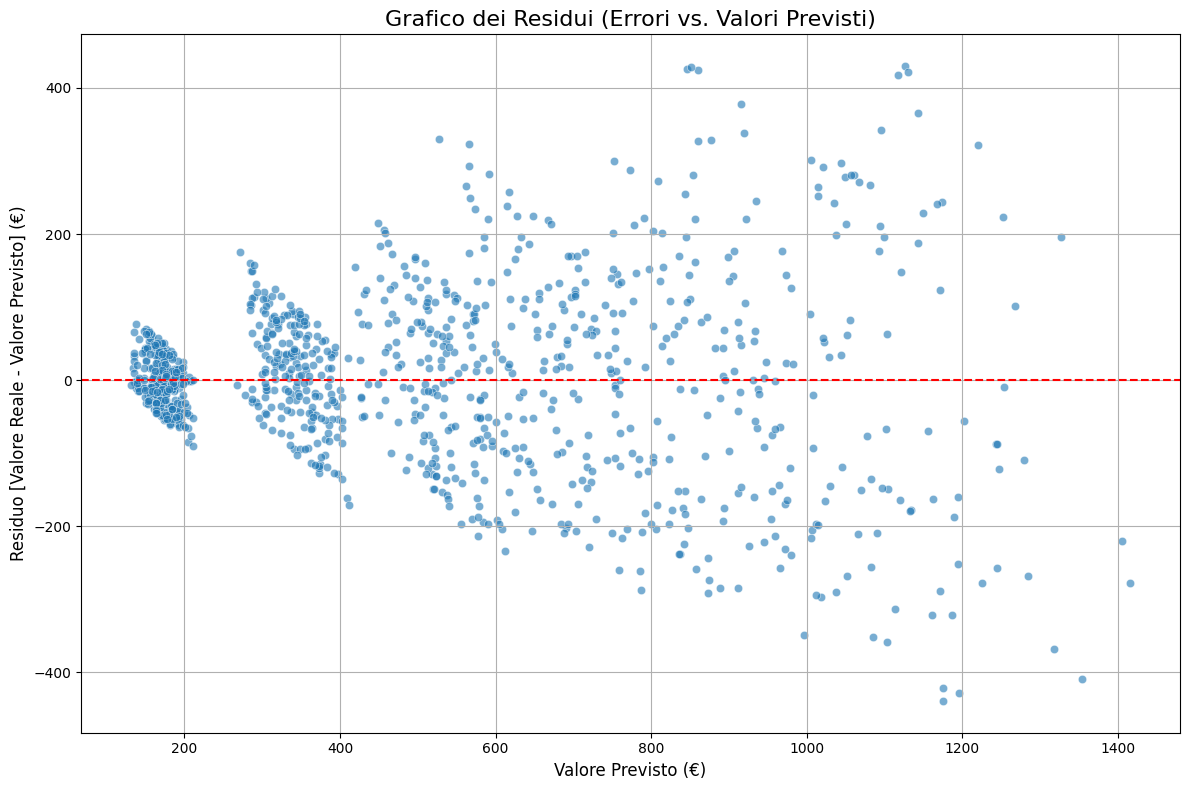

In [0]:

# --- 5. Visualizzazione e Analisi del Modello (IL PUNTO CHIAVE) ---
print("\n📊 Generazione Grafici di Analisi...")

# Prepara la cartella per salvare i grafici
cartella_grafici = Path('grafici')
cartella_grafici.mkdir(parents=True, exist_ok=True)

# GRAFICO 1: Analisi dei Residui
residuals = y_test - y_pred
plt.figure(figsize=(12, 8))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Grafico dei Residui (Errori vs. Valori Previsti)', fontsize=16)
plt.xlabel('Valore Previsto (€)', fontsize=12)
plt.ylabel('Residuo [Valore Reale - Valore Previsto] (€)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('grafici/residuals_plot.png')
plt.show()
plt.close()


RESIDUALS PLOT 
Mette in relazione il prezzo previsto dal modello (asse X) con l'errore commesso (asse Y). L'errore è calcolato come Prezzo Reale - Prezzo Previsto. La linea rossa tratteggiata rappresenta l'errore zero (previsione perfetta).

Analisi: Si nota chiaramente una forma a cono (o a imbuto).

A sinistra (prezzi bassi, < 400€), i punti sono molto vicini alla linea rossa. Qui il modello è molto preciso.

Spostandosi a destra (prezzi più alti), i punti si disperdono sempre di più, sia verso l'alto (sottostime) che verso il basso (sovrastime). Qui il modello diventa inaffidabile.

Diagnosi: Il modello soffre di eteroscedasticità. In parole semplici, l'entità del suo errore non è costante, ma aumenta all'aumentare del prezzo. È molto affidabile nel prezzare soggiorni economici ma perde progressivamente accuratezza su quelli più costosi.

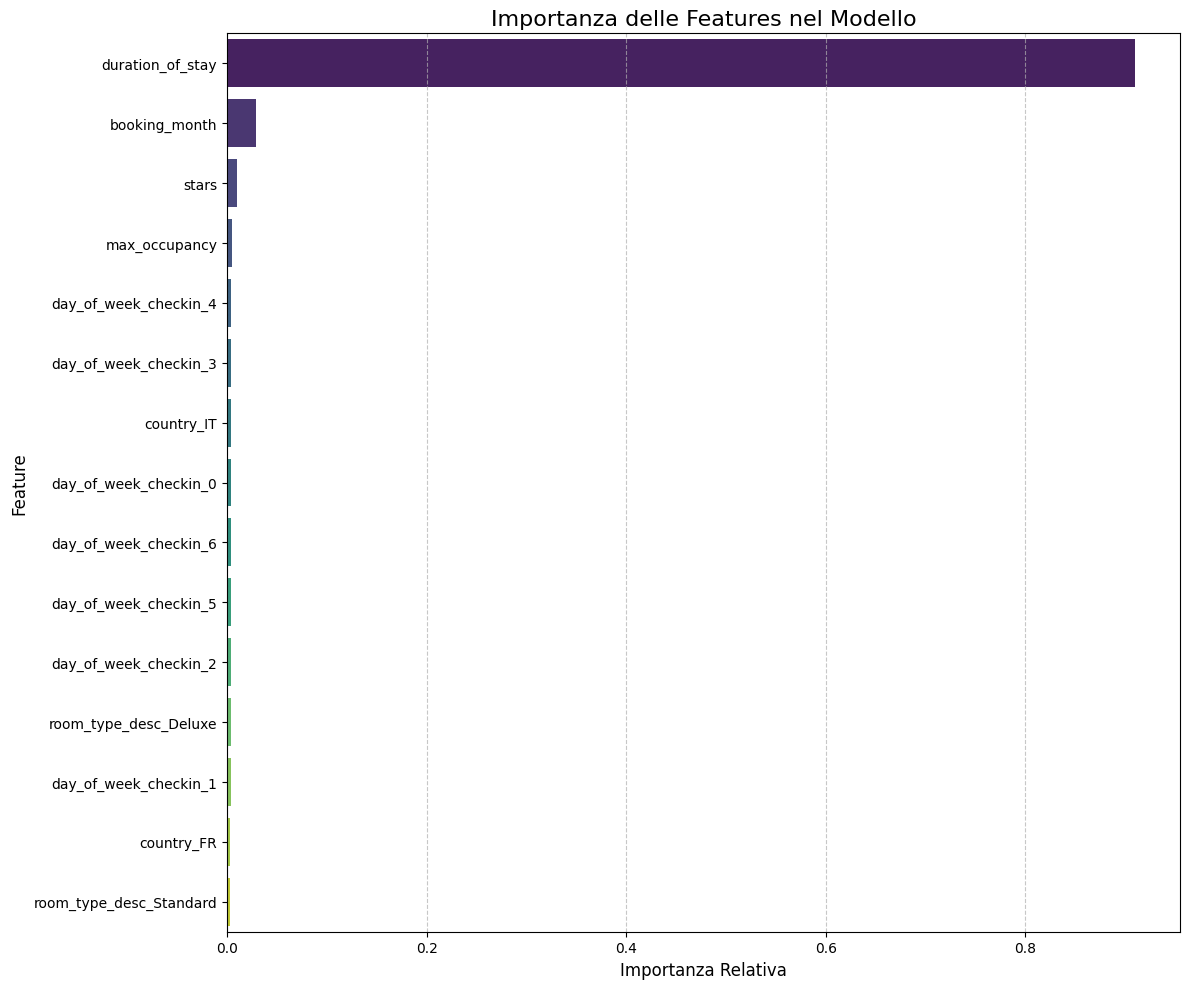

In [0]:

# GRAFICO 2: Importanza delle Features
feature_names = numeric_features + list(model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))
importances = model.named_steps['regressor'].feature_importances_
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).head(15)
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis', hue='feature', legend=False)
plt.title('Importanza delle Features nel Modello', fontsize=16)
plt.xlabel('Importanza Relativa', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('grafici/feature_importance.png')
plt.show()
plt.close()


FEATURE IMPORTANCE 
Questo grafico classifica le variabili (features) in base a quanto hanno influenzato le previsioni del modello. Una barra più lunga significa che la feature è più importante.

Analisi: È evidente che la duration_of_stay (durata del soggiorno) è di gran lunga la feature più importante, quasi al 90%. Tutte le altre variabili hanno un'importanza quasi trascurabile in confronto.

Diagnosi: Il tuo modello al momento è molto semplice. Basa le sue previsioni quasi esclusivamente su un solo fattore. Sebbene sia logico che la durata del soggiorno sia il driver principale del prezzo, questa dipendenza eccessiva significa che il modello sta ignorando le sfumature che differenziano una prenotazione costosa da una economica a parità di durata.

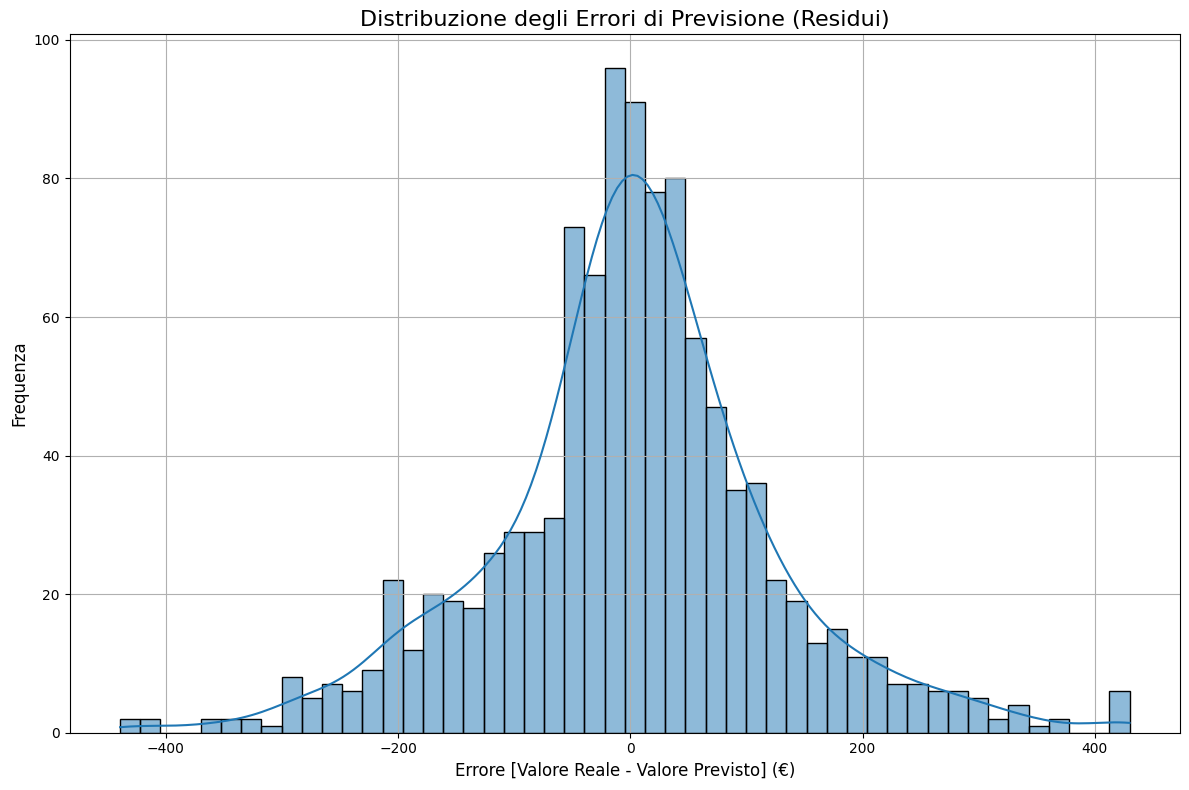

✅ Grafici generati con successo.


In [0]:

# GRAFICO 3: Distribuzione degli Errori
plt.figure(figsize=(12, 8))
sns.histplot(residuals, kde=True, bins=50)
plt.title('Distribuzione degli Errori di Previsione (Residui)', fontsize=16)
plt.xlabel('Errore [Valore Reale - Valore Previsto] (€)', fontsize=12)
plt.ylabel('Frequenza', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('grafici/residuals_distribution.png')
plt.show()
plt.close()

print("✅ Grafici generati con successo.")


RESIDUAL DISTRIBUTION 
È un istogramma che mostra la frequenza dei vari errori.

Analisi: La distribuzione ha una forma a campana (gaussiana) ed è centrata sullo zero.

Diagnosi: Questo è un ottimo segno. Significa che il modello non ha un bias sistematico: non tende a sovrastimare o sottostimare costantemente. L'errore più frequente è vicino a zero, e gli errori positivi e negativi sono distribuiti in modo simile. In sintesi, quando sbaglia, lo fa in modo casuale e non sistematico.

In [0]:

# --- 6. Previsione Finale e Salvataggio dei risultati ---
print("\n🚀 Salvataggio delle previsioni finali...")

#generate previsioni sull'intero dataset
predictions = model.predict(X).astype(float)
data['predicted_price'] = predictions

output_spark_df = spark.createDataFrame(data)

output_table_name = f"{catalog}.gold_schema_pf.bookings_predictions_final"
output_spark_df.write.mode("overwrite").option("overwriteSchema", "true").saveAsTable(output_table_name)

print(f"✅ Le previsioni sono state salvate nella tabella Gold: '{output_table_name}'")


🚀 Salvataggio delle previsioni finali...
✅ Le previsioni sono state salvate nella tabella Gold: 'catalog_progetto_finale.gold_schema_pf.bookings_predictions_final'


Diagnosi Finale: il modello è equilibrato e non distorto, ma troppo semplice. Si affida quasi esclusivamente alla durata del soggiorno e, di conseguenza, è bravo a prevedere i prezzi bassi ma non ha abbastanza informazioni per prevedere con accuratezza i prezzi alti, dove entrano in gioco altri fattori.